# Compare ROMS with ARGO profiler data


In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask_jobqueue import SLURMCluster

In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(36)
client


Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Client Scheduler: tcp://146.118.38.45:33424 Dashboard: http://146.118.38.45:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from datetime import datetime
from scipy.interpolate import PchipInterpolator

from glob import glob
from matplotlib import rcParams
from soda.dataio.roms.romsio import  get_depth
from soda.utils.inpolygon import inpolygon

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "12"
rcParams['axes.labelsize']='medium'



/home/mrayson/code/soda/soda/dataio/netcdfio.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ncmeta = yaml.load(f)


Warning - could not import octant package.


In [4]:
# Standard ARGO variable names
timevar = 'JULD'
xvar = 'LONGITUDE'
yvar = 'LATITUDE'
zvar = 'PRES_ADJUSTED'
zvar_qc = 'PRES_ADJUSTED_QC'
tvar = 'TEMP_ADJUSTED'
tvar_qc = 'TEMP_ADJUSTED_QC'

def load_argo_T(argofile, zout):
    ds = xr.open_dataset(argofile)
    z = ds[zvar].values[0,:].squeeze()
    T = ds[tvar].values[0,:].squeeze()
    #zu, idx = np.unique(z, return_index=True)
    #Tu = T[idx]
    idx = (~np.isnan(z)) & (~np.isnan(T))
    zu = z[idx]
    Tu = T[idx]
    #print(Tu, zu)
    #print(argofile, z.shape, Tu.shape, T.shape, zu.shape)

    T_da = xr.DataArray(Tu, coords={'pressure':zu}, dims=('pressure',), attrs=ds[tvar].attrs)
    ds_out = xr.Dataset({'watertemp':T_da, xvar:ds[xvar],yvar:ds[yvar], timevar:ds[timevar]})
    #print(T_da.interp({'pressure':zout}))
    return ds_out.interp({'pressure':zout})

In [5]:
argofiles = glob('../ObsData/*.nc')


In [6]:
# load_argo_T('../ObsData/D5901680_306.nc',zout)

In [7]:
# Look at an argo file
ds = xr.open_dataset(argofiles[0])

# Use the depths from the first file as the standard depths
zout = ds[zvar].values.squeeze()

zout

array([   4.2,    9. ,   14.4,   19.2,   24.3,   29.3,   34.4,   39.6,
         44.5,   49.4,   54.9,   59.6,   69.7,   79.4,   89.6,   99.6,
        109.6,  119.4,  129.4,  139.6,  149.6,  159.4,  169.3,  179.3,
        189.7,  199.4,  209.4,  219.3,  229.1,  239. ,  249. ,  259.2,
        269.6,  279.4,  299.2,  319.5,  339.2,  359.2,  378.9,  399.2,
        419.2,  439. ,  459.3,  478.8,  499.2,  549.4,  598.9,  649.4,
        699.1,  749.2,  799. ,  849.1,  899.5,  949. ,  999.3, 1049.4,
       1099.2, 1149.3, 1198.9, 1249.2, 1299.5, 1348.9, 1399.1, 1449. ,
       1499.3, 1599.3, 1699. , 1799.1, 1899.2, 1986.8], dtype=float32)

In [8]:
# Stack them all together
T = xr.concat([load_argo_T(argofile,zout) for argofile in argofiles] ,'N_PROF')

In [9]:
T

<xarray.Dataset>
Dimensions:    (N_PROF: 306, pressure: 70)
Coordinates:
  * pressure   (pressure) float32 4.2 9.0 14.4 19.2 ... 1799.1 1899.2 1986.8
Dimensions without coordinates: N_PROF
Data variables:
    watertemp  (N_PROF, pressure) float32 26.518 26.518 ... 2.5935001 2.4328942
    LONGITUDE  (N_PROF) float64 108.0 117.3 107.7 103.0 ... 116.3 120.6 117.2
    LATITUDE   (N_PROF) float64 -18.55 -13.83 -12.07 ... -14.73 -16.78 -14.91
    JULD       (N_PROF) datetime64[ns] 2017-05-08T22:33:59.000031232 ... 2017...

In [20]:
# Load a ROMS file
romsvar = 'temp'

## 4Dvar run
romsfiles = glob('/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/archive_fwd2_*.nc')
myroms = xr.open_mfdataset(romsfiles, concat_dim='ocean_time', parallel=True)
outfile = '../DATA/ROMS_4DVar_ARGO_temp.nc'

## Standalone run

# myroms = xr.open_mfdataset('../ROMSdata/outputs/roms_nws_*his.nc', concat_dim='ocean_time', 
#                         parallel=True)
# outfile = '../DATA/ROMS_ARGO_temp.nc'


# DRop non-unique time variables
_, index = np.unique(myroms['ocean_time'], return_index=True)
roms =myroms[romsvar].isel(ocean_time=index).chunk({'ocean_time':1})
roms

<xarray.DataArray 'temp' (ocean_time: 1441, s_rho: 30, eta_rho: 482, xi_rho: 1010)>
dask.array<rechunk-merge, shape=(1441, 30, 482, 1010), dtype=float64, chunksize=(1, 30, 482, 1010), chunktype=numpy.ndarray>
Coordinates:
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time  (ocean_time) datetime64[ns] 2017-02-01 ... 2017-06-01
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  potential temperature
    units:      Celsius
    time:       ocean_time
    grid:       grid
    location:   face
    field:      temperature, scalar, series

In [21]:
# Function to find the nearest ROMS point
grid = xr.open_dataset('/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/archive_fwd2_6241.nc')
xroms = grid.lon_rho.values
yroms = grid.lat_rho.values



In [22]:
# Create a polyon
xpoly = [xroms[0,0], xroms[0,-1], xroms[-1,-1], xroms[-1,0], xroms[0,0]]
ypoly = [yroms[0,0], yroms[0,-1], yroms[-1,-1], yroms[-1,0], yroms[0,0]]
idx = inpolygon(np.array([T[xvar].values, T[yvar].values]).T,np.array([xpoly,ypoly]).T)
idx

array([False,  True,  True, False, False, False, False,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False, False,  True,  True, False, False,  True,  True, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True, False, False,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True, False,  True,  True,
       False, False, False, False, False,  True,  True, False,  True,
       False, False,  True,  True,  True,  True, False,  True,  True,
       False, False,  True, False, False,  True, False,  True,  True,
       False,  True, False,  True,  True,  True,  True, False, False,
        True, False, False, False,  True, False, False, False,  True,
       False, False,

157


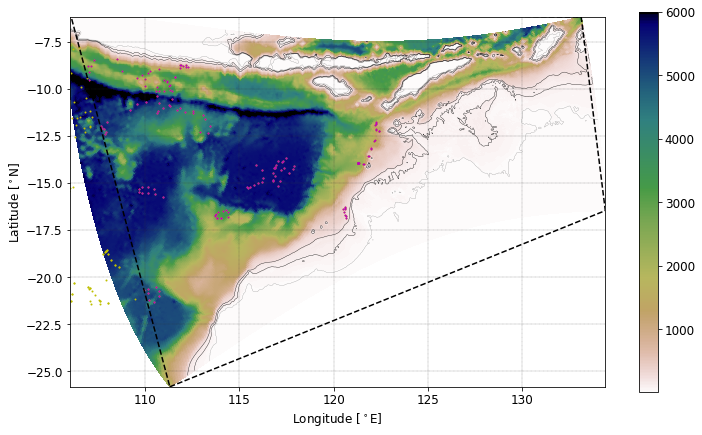

In [23]:
plt.figure(figsize=(12,7))
plt.pcolormesh(xroms,yroms, grid.h[...],cmap='gist_earth_r')
plt.colorbar()

plt.contour(xroms,yroms, grid.h[...],[20],colors='0.5',linewidths=0.25)
plt.contour(xroms,yroms, grid.h[...],[100,200],colors='k',linewidths=0.35)

plt.plot(T[xvar].values, T[yvar].values,'y.', ms=2)
plt.plot(T[xvar].values[idx], T[yvar].values[idx],'m.', ms=2)

plt.plot(xpoly, ypoly,'k--')
plt.gca().set_aspect('equal')
plt.xlim(xroms[-1,0], xroms[0,-1])
plt.ylim(yroms[0,0], yroms[-1,-1])
plt.ylabel('Latitude [$^\circ$N]')
plt.xlabel('Longitude [$^\circ$E]')
plt.grid(b=True, ls='--',c='0.2',lw=0.25)
plt.savefig('../FIGURES/ARGO_Map.png',dpi=150)
print(idx.sum())

In [24]:
@dask.delayed
def get_depth_delayed(s, Cs, hc, h):
    return get_depth(s, Cs, hc, h)

In [27]:
# Get the point
def get_roms(xpt, ypt, timept):
    dist = np.abs( (xpt-xroms) + 1j*(ypt-yroms))
    idx = np.argwhere(dist==dist.min())
    J,I = idx[0,0],idx[0,1]
    #temp = roms['temp'].isel(eta_rho=J, xi_rho=I).sel(ocean_time=timept, method='nearest')
    temp = roms.sel(ocean_time=timept, method='nearest').isel(eta_rho=J, xi_rho=I)

    #h = roms['h'].isel(eta_rho=J, xi_rho=I)
    #zroms = get_depth(temp.s_rho.values, roms.Cs_r.values[0,:], roms.hc.values[0], h)
    #zroms = get_depth_delayed(temp.s_rho, roms.Cs_r[0,:], roms.hc[0], h[0])

    return temp, J, I #,xr.DataArray(temp, coords={'depth':zroms}, dims=('depth',))



In [28]:
tempall = []
jj = []
ii = []
for xpt, ypt, timept in zip(T[xvar].values[idx], T[yvar].values[idx], T[timevar].values[idx]):
    temp, J,I = get_roms(xpt, ypt, timept)
    tempall.append(temp)
    jj.append(J)
    ii.append(I)

In [29]:
ds = xr.concat(tempall, dim='ocean_time').compute()
ds

KilledWorker: ("('concatenate-getitem-open_dataset-rechunk-merge-6849ab5f3a02a80fa2880a8a4dfa04fb', 19, 0, 0, 0)", <Worker 'tcp://146.118.38.74:35270', name: 7-3, memory: 0, processing: 46>)

In [ ]:
grid.Cs_r, grid.hc

In [ ]:
# Compute the depths
ctr=0
zromsall = []
hall = []
lon_rho =[]
lat_rho =[]

for J,I in zip(jj,ii):
    h = grid['h'].isel(eta_rho=J, xi_rho=I)
    lon = xroms[J,I]#grid['lon_rho'].isel(eta_rho=J, xi_rho=I)
    lat = yroms[J,I]#grid['lat_rho'].isel(eta_rho=J, xi_rho=I)

    #zroms = get_depth(temp.s_rho.values, roms.Cs_r.values[0,:], roms.hc.values[0], h)
    zroms = get_depth_delayed(temp.s_rho, grid.Cs_r, grid.hc, h)
    zromsall.append(zroms)
    hall.append(h)
    lon_rho.append(lon)
    lat_rho.append(lat)
    
zromsall = dask.compute(*zromsall)
Z = np.array(zromsall)

In [ ]:
for ii in range(157):
    plt.plot( ds[ii,:], Z[ii,:])

In [ ]:
# Loop through and interpolate all of the temperature onto ARGO depths
nx, nz = Z.shape
nzout = zout.shape[0]
Troms_i = np.zeros((nx,nzout))
for ii in range(nx):
    F = PchipInterpolator(Z[ii,:], ds[ii,:],extrapolate=False) # Return NaNs when out of bounds
    Troms_i[ii,:] = F(-zout)

In [ ]:
Tobs_ds = T.isel(N_PROF=idx)
Tobs_ds

In [ ]:
# Output the interpolated ROMS into the same format
T_da = xr.DataArray(Troms_i, coords={'pressure':zout},\
                dims=('N_PROF','pressure',), attrs=roms['temp'].attrs)
lon_ds = xr.DataArray(lon_rho,dims=('N_PROF',))
lat_ds = xr.DataArray(lat_rho,dims=('N_PROF',))
Tmod_ds = xr.Dataset({'watertemp':T_da, xvar:lon_ds,yvar:lat_ds, timevar:ds['ocean_time'].values})
Tmod_ds

In [ ]:
Tmod_ds.to_netcdf(outfile)
print(outfile)
# Tobs_ds.to_netcdf('../DATA/ARGO_gridded_temp.nc')